---
# Predicting Anime Scores

In this notebook, we will prepare features, split the data, train baseline regression models, and evaluate their performance.

In [15]:
# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

---
## 1. Load Cleaned Dataset

In [16]:
# Load the processed dataset
df = pd.read_csv("../data/processed/clean_anime_full.csv")
df.head()

,title,type,source,episodes,status,rating,score,scored_by,rank,popularity,members,favorites,year,season,has_year,has_season,genres,demographics
0,Sousou no Frieren,Tv,Manga,28,Finished Airing,PG-13 - TEENS 13 OR OLDER,9.30,686846.0,1,139,1157346,71546,2023,Fall,1,1,"Adventure, Drama, Fantasy",Shounen
1,Fullmetal Alchemist: Brotherhood,Tv,Manga,64,Finished Airing,R - 17+ (VIOLENCE & PROFANITY),9.10,2227771.0,2,3,3539957,234693,2009,Spring,1,1,"Action, Adventure, Drama, Fantasy",Shounen
2,Steins;Gate,Tv,Visual Novel,24,Finished Airing,PG-13 - TEENS 13 OR OLDER,9.07,1470245.0,3,14,2711161,196638,2011,Spring,1,1,"Drama, Sci-Fi, Suspense",NaN
3,Shingeki no Kyojin Season 3 Part 2,Tv,Manga,10,Finished Airing,R - 17+ (VIOLENCE & PROFANITY),9.05,1705642.0,4,21,2462353,61277,2019,Spring,1,1,"Action, Drama, Suspense",Shounen
4,Gintama°,Tv,Manga,51,Finished Airing,PG-13 - TEENS 13 OR OLDER,9.05,264741.0,5,342,670599,17213,2015,Spring,1,1,"Action, Comedy, Sci-Fi",Shounen


---
## 2. Feature Engineering
- Drop unused or redundant columns (title, favorites, etc.)
- Encode categorical columns (type, source, etc.)
- Scale numerical features.

In [17]:
# Drop unused or redundant columns
df = df.drop(columns=["title", "favorites", "has_year", "has_season"])

# Define categorical and numeric columns
categorical_cols = ["type", "source", "status", "rating", "season", "genres", "demographics"]
numeric_cols = df.drop(columns=categorical_cols + ["score"]).select_dtypes(include=["int64", "float64"]).columns.tolist()

In [18]:
# Define features and target
correlations = df[numeric_cols + ["score"]].corr()
correlations["score"].sort_values(ascending=False)

score         1.000000
members       0.239580
year          0.234040
scored_by     0.210936
episodes     -0.065559
rank         -0.135660
popularity   -0.770455
Name: score, dtype: float64

In [19]:
# Define features and target
X = df.drop(columns=["score"])
y = df["score"]

---
## 3. Train-Test Split
We split the dataset into training and testing sets using an 80:20 ratio to evaluate model performance on unseen data.

In [20]:
# 80:20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

---
## 4. Train Baseline Models
- Linear Regression
- Random Forest

In [21]:
# Preprocessing
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Pipelines
pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# Fit models
pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


---
## 5. Evaluate Models
- Use MAE, RMSE, R²

In [22]:
def evaluate_model(name, y_true, y_pred):
    print(f"{name} Evaluation")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred):.4f}")
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2_score(y_true, y_pred):.4f}")
    print("-" * 30)

# Predictions
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluation
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)

Linear Regression Evaluation
MAE  : 1.5734
RMSE : 2.1717
R²   : 0.6375
------------------------------
Random Forest Evaluation
MAE  : 0.0549
RMSE : 0.1844
R²   : 0.9974
------------------------------


The Random Forest model is more complex and may overfit the training data.
To check for overfitting, we can compare the training and testing performance.

---
## 7. Check for Overfitting in Random Forest Models
- Compare training vs testing performance
- Visualize predicted vs actual values

=== R² Comparison ===
Training R²: 0.9996
Testing R² : 0.9974

=== RMSE Comparison ===
Training RMSE: 0.0724
Testing RMSE : 0.1844


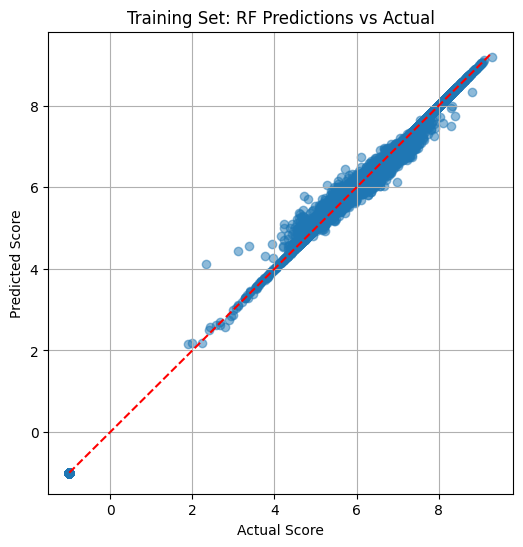

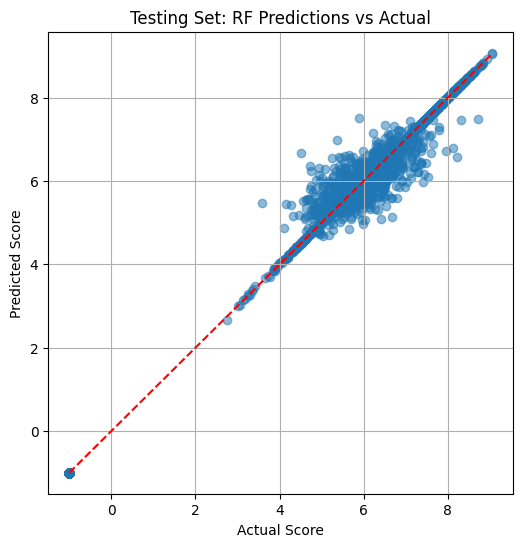

In [23]:
# Overfitting Check only for Random Forest
# Predict on training set
y_train_pred_rf = pipeline_rf.predict(X_train)

# Training vs Testing R²
train_r2 = r2_score(y_train, y_train_pred_rf)
test_r2 = r2_score(y_test, y_pred_rf)

print("=== R² Comparison ===")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing R² : {test_r2:.4f}")

# RMSE comparison
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\n=== RMSE Comparison ===")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE : {test_rmse:.4f}")

# Scatter Plot: Training Set Predictions vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_train_pred_rf, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Training Set: RF Predictions vs Actual")
plt.grid(True)
plt.show()

# Scatter Plot: Testing Set Predictions vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Testing Set: RF Predictions vs Actual")
plt.grid(True)
plt.show()

---
## 8. Feature Importance

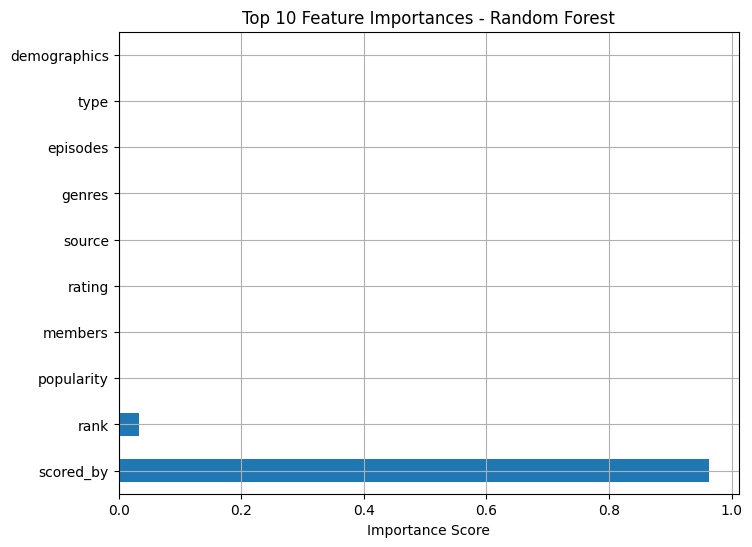

In [24]:
# Feature Importance
rf_model = pipeline_rf.named_steps["regressor"]

# Get feature names after transformation
cat_encoder = pipeline_rf.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = list(numeric_cols) + list(cat_feature_names)

importances = rf_model.feature_importances_
feat_importance = pd.Series(importances, index=feature_names)

# Plot
plt.figure(figsize=(8, 6))
feat_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.grid(True)
plt.show()

We know that the scored_by feature is highly correlated with the score.
The is a possibility that the model is overfitting to this feature.
We can check it by removing the scored_by feature and retraining the model.

In [25]:
# Remove 'scored_by' column for no-leakage model
numeric_cols_nl = [col for col in numeric_cols if col != "scored_by"]

# Preprocessing for no-leakage model
categorical_transformer_nl = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

numeric_transformer_nl = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor_nl = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_nl, numeric_cols_nl),
        ("cat", categorical_transformer_nl, categorical_cols)
    ]
)

# Pipelines for no-leakage model
pipeline_rf_nl = Pipeline([
    ("preprocessor", preprocessor_nl),
    ("regressor", RandomForestRegressor(random_state=42))
])
# Fit no-leakage model
X_noleak = X.drop(columns=["scored_by"])
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_noleak, y, test_size=0.2, random_state=42)

pipeline_rf_nl.fit(X_train_nl, y_train_nl)
y_pred_rf_nl = pipeline_rf_nl.predict(X_test_nl)

# Evaluate no-leakage model
print("=== No-Leakage Model Evaluation ===")
evaluate_model("Random Forest (No scored_by)", y_test_nl, y_pred_rf_nl)

=== No-Leakage Model Evaluation ===
Random Forest (No scored_by) Evaluation
MAE  : 0.1124
RMSE : 0.5324
R²   : 0.9782
------------------------------


In [26]:
# Grid Search for best Random Forest (no-leakage)
param_grid = {
    "regressor__n_estimators": [50, 100, 200],
    "regressor__max_depth": [10, 20, None],
    "regressor__min_samples_split": [2, 5],
}

grid_search = GridSearchCV(
    pipeline_rf_nl, param_grid, cv=3, scoring="r2", n_jobs=-1, verbose=1
)

grid_search.fit(X_train_nl, y_train_nl)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Evaluate best model
y_pred_best = best_model.predict(X_test_nl)
evaluate_model("Tuned RF (No scored_by)", y_test_nl, y_pred_best)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}
Tuned RF (No scored_by) Evaluation
MAE  : 0.1120
RMSE : 0.5235
R²   : 0.9789
------------------------------


---
## 9. Cross-validation with the best model

Cross-validation AFTER tuning and WITHOUT 'scored_by' feature.
This avoids data leakage and uses the best tuned model (best_model).

Improvement steps taken:
- Use cross-validation with `KFold(shuffle=True)`
- Re-tuning with model complexity constraints
- Re-validate GridSearch results with cross-validation

In [27]:
# 9. Cross-validation after tuning the best model

# Generate KFold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation on the best model
cv_scores_best = cross_val_score(best_model, X_noleak, y, cv=cv, scoring="r2")

print("=== Cross-Validation After Tuning (Best Model) ===")
print(f"Scores: {cv_scores_best}")
print(f"Mean  : {cv_scores_best.mean():.4f}")
print(f"Std   : {cv_scores_best.std():.4f}")
print("-" * 30)

=== Cross-Validation After Tuning (Best Model) ===
Scores: [0.97898532 0.98161932 0.98378943 0.98263061 0.97654385]
Mean  : 0.9807
Std   : 0.0026
------------------------------


---
### Cross-Validation: Correct and Clean Evaluation

After tuning, we validate the best Random Forest model using 5-fold cross-validation with shuffling (`KFold`).

- This avoids any data leakage or improper reuse of fitted data.
- Evaluation is done on the full dataset with `scored_by` removed.
- Final model is `best_model`, selected from `GridSearchCV`.

**Result:**
- Mean R² ≈ 0.9807
- Std ≈ 0.0026

The model generalizes very well and shows no signs of overfitting.

---
## 10. Save Best Model

In [28]:
# For now i stil wan't to explore much more models
# We still can try other models like XGBoost, LightGBM, or even deep learning models.
# But for now, we will save the best model we have.

joblib.dump(best_model, "../models/best_random_forest_model.pkl")

['../models/best_random_forest_model.pkl']